# Source data exploration

In this notebook we do the data analysis and exploratory for the Source data of the Now Corpus. Notebook consists of 3 main parts: Merging of the source data, general data exploration of the source data and topic assignment from url.

In [1]:
#imports
import pandas as pd
import numpy as np
from collections import Counter
import re
import csv
import seaborn as sns
import matplotlib.pylab as plt

import gensim
from gensim.parsing.preprocessing import STOPWORDS

import warnings
warnings.filterwarnings('ignore')
# Import stopwords with nltk.
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
stop = stopwords.words('english')


[nltk_data] Downloading package stopwords to /home/gorkem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Part 1: Read and Merge the Source data

In [2]:
#Read the data
data_folder = '../sample_data/'
source1 = pd.read_table(data_folder+'now_sources_pt1.txt',encoding = "ISO-8859-1", header=None)
source2 = pd.read_table(data_folder+'now_sources_pt2.txt',encoding = "ISO-8859-1", header=None)
#sources.dropna(axis=1, inplace=True)
source1.rename(columns={0:'textID', 1:'#words',2:'date',3:'country',4:'website',5:'url',6:'title'}, inplace=True)
source1.head()
source2.rename(columns={0:'textID', 1:'#words',2:'date',3:'country',4:'website',5:'url',6:'title'}, inplace=True)
source2.head()

,textID,#words,date,country,website,url,title
0,2930853,194,15-01-01,US,Consequence of Sound,http://consequenceofsound.net/2015/01/100000-c...,100000 copies of The Interview will be dropped...
1,2930854,266,15-01-01,US,Los Angeles Times,http://www.latimes.com/entertainment/movies/la...,'The Taking of Tiger Mountain' gets blockbuste...
2,2930855,701,15-01-01,US,TIME,http://time.com/3651697/afghanistan-war-cost/,The True Cost of the Afghanistan War May Surpr...
3,2930856,1963,15-01-01,US,The Week Magazine,http://theweek.com/articles/441310/confessions...,Confessions of a former TSA officer
4,2930859,263,15-01-01,US,Russia Beyond the Headlines,http://rbth.com/arts/2015/01/01/year_of_litera...,"Pushkin, Gogol and Akhmatova to be symbols of ..."


In [3]:
# Concat the 2 sources file content
frames = [source1, source2]
sources = pd.concat(frames)

In [4]:
# Total shape of the final data
sources.shape

(6132175, 7)

From above we can say that we have 6 million articles for over 10 years of data.

In [5]:
sources.dtypes

textID      int64
#words      int64
date       object
country    object
website    object
url        object
title      object
dtype: object

In [6]:
#Turn the date to date form - first we need to add the 20 in from of years since years were given 2 digitis
sources.date =  '20'+sources.date
sources.date =  pd.to_datetime(sources.date, format='%Y-%m-%d')

In [7]:
# check the dates are correctly changed and the date type
display(sources.head())
display(sources.dtypes)

,textID,#words,date,country,website,url,title
0,1334669,334,2010-01-01,US,The Next Web,http://thenextweb.com/2010/01/01/avatar-takes-...,Believe it or not: Avatar takes 1 petabyte of ...
1,1334671,493,2010-01-01,US,People Magazine,"http://www.people.com/people/article/0,,203339...",INSIDE STORY: The Making of Beyonc's 'Single ...
2,1334672,1255,2010-01-01,US,San Francisco Chronicle,http://www.sfgate.com/bayarea/article/Biblical...,"Biblical scholar's date for rapture: May 21, 2011"
3,1334673,695,2010-01-01,US,CNN,http://www.cnn.com/2010/HEALTH/01/01/multi.vit...,What you need to know about multivitamins
4,1334674,724,2010-01-01,US,MedPage Today,http://www.medpagetoday.com/Psychiatry/sleepdi...,Lack of Sleep Linked to Depression in Adolescents


textID              int64
#words              int64
date       datetime64[ns]
country            object
website            object
url                object
title              object
dtype: object

### Part 2: General Data Exploration for Source Data

We tried to answer basic questions about the now orpus data first. 
- How many unique countries we have and which ones?
- How many unique websites?
- How many articles per country and website?
- How many websites per country?   
Answering these type of question gives us a better understand of the data and preliminary stats about the countries and website resources.

In [8]:
# how many unique country?
print(sources.country.unique())
print(len(sources.country.unique()))

['US' 'CA' 'GB' 'IE' 'AU' 'NZ' 'IN' 'LK' 'PK' 'BD' 'MY' 'SG' 'PH' 'HK'
 'ZA' 'NG' 'GH' 'KE' 'TZ' 'JM']
20


In [9]:
# how many unique website?
print(sources.website.unique())
print(len(sources.website.unique()))

['The Next Web' 'People Magazine' 'San Francisco Chronicle' ...
 'Reggaeville.com' 'Loop Jamaica (press release) (registration) (blog)'
 'Television Jamaica']
20733


In [10]:
# There is any NAN value?  - the nulls are in the website name
sources.isnull().any().any()

True

In [11]:
sources.isnull().any()

textID     False
#words     False
date       False
country    False
website     True
url        False
title      False
dtype: bool

In [12]:
# Are there duplicate lines?
sources.duplicated().any()

False

We see that we have 20 english speaking countries, a total of 20733 unique website resources that articles collected and there is no duplicate data. Only for some data there is null website name.

#### Answering Data Related Questions

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
country,AU,BD,CA,GB,GH,HK,IE,IN,JM,KE,LK,MY,NG,NZ,PH,PK,SG,TZ,US,ZA
textID,441036,36680,788162,823458,103062,25780,469298,729178,41995,104030,37020,150313,225097,250814,233322,205199,208031,15848,857301,386551


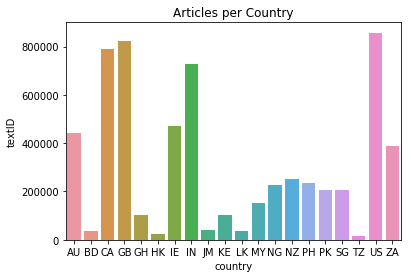

In [13]:
# How many articles per country?
articles_per_country = sources.groupby(by=['country'])['textID'].count()
articles_per_country = pd.DataFrame(articles_per_country)
articles_per_country = articles_per_country.reset_index()
display(articles_per_country.T)
ax = sns.barplot(x="country", y="textID", data=articles_per_country).set_title('Articles per Country')

In [14]:
articles_per_country.describe().T

,count,mean,std,min,25%,50%,75%,max
textID,20.0,306608.75,285876.010642,15848.0,87795.25,216564.0,448101.5,857301.0


We see that US has the more articles compared to other countries.The least articles belong to Tanzania with 15848 articles. In average countries has around 306608 articles.

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
country,AU,BD,CA,GB,GH,HK,IE,IN,JM,KE,LK,MY,NG,NZ,PH,PK,SG,TZ,US,ZA
website,1161,49,1587,3797,91,148,312,1057,22,115,125,174,175,362,368,269,272,26,11221,428


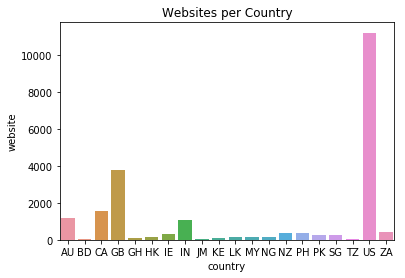

In [15]:
# How many website per country?   (count distinct websites)
websites_per_country = sources.groupby(by=['country'])['website'].nunique()
websites_per_country = pd.DataFrame(websites_per_country)
websites_per_country = websites_per_country.reset_index()
display(websites_per_country.T)
ax = sns.barplot(x="country", y="website", data=websites_per_country).set_title('Websites per Country')

In [16]:
websites_per_country.describe().T

,count,mean,std,min,25%,50%,75%,max
website,20.0,1087.95,2538.710022,22.0,122.5,270.5,585.25,11221.0


The most resources again belongs to US with 11221 resource website. The resource number is less for the other countries 75% of the countries has less than around 585 resources. The minimum resource website belongs to Jamaica with 22 distinct websites.

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
country,AU,BD,CA,GB,GH,HK,IE,IN,JM,KE,LK,MY,NG,NZ,PH,PK,SG,TZ,US,ZA
#words,280223620,17899964,519548548,537543670,43738013,14120315,241347866,383914249,24693984,43621653,20122787,69214059,120554068,123016733,117067124,94028598,92041860,7941870,678812809,208964697


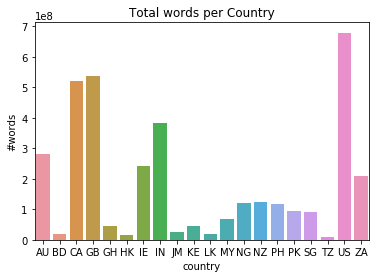

In [17]:
# How many total words per country?
words_per_country = sources.groupby(by=['country'])['#words'].sum()
words_per_country = pd.DataFrame(words_per_country)
words_per_country = words_per_country.reset_index()
display(words_per_country.T)
ax = sns.barplot(x="country", y="#words", data=words_per_country).set_title('Total words per Country')

In [18]:
words_per_country.describe().T

,count,mean,std,min,25%,50%,75%,max
#words,20.0,1.819208e+08,1.995371e+08,7941870.0,38889735.75,105547861.0,251066804.5,678812809.0


We also explore total number of words in articles per country. According to th above results, US again has the most word count which makes sense since they have more articles collected. Overall, for each country we have at least 8 million of words collected.

,0,1,2,3,4,5,6,7,8,9,...,20722,20723,20724,20725,20726,20727,20728,20729,20730,20731
website,Times of India,Telegraph.co.uk,Daily Mail,Independent Online,Irish Independent,Stuff.co.nz,ABC Online,Inquirer.net,Irish Times,The Guardian,...,Newsroom America,Newsport (press release) (registration),Director of Finance online,WHOTV.com,DisZine,Disaster News Network,Newspaper Tree,Discover Moose Jaw,Discover San Diego,WPSuperfanboy
textID,163277,112186,110912,79541,68906,65847,61355,61175,59725,57486,...,1,1,1,1,1,1,1,1,1,1


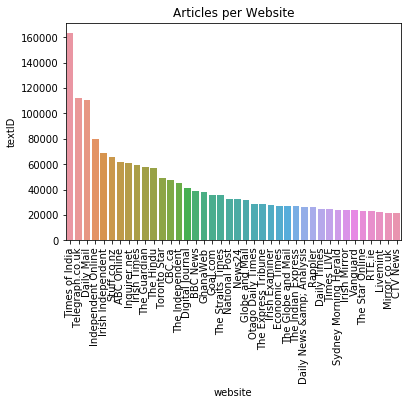

In [19]:
# How many articles per website?
articles_per_website = sources.groupby(by=['website'])['textID'].count()
articles_per_website.sort_values(ascending=False, inplace=True)
#print(articles_per_website.head(25))
articles_per_website = pd.DataFrame(articles_per_website)
articles_per_website = articles_per_website.reset_index()
display(articles_per_website.T)
ax1 = sns.barplot(x="website", y="textID", data=articles_per_website[:40]).set_title('Articles per Website')
plt.xticks(rotation=90)
plt.show()

In [20]:
articles_per_website.describe().T

,count,mean,std,min,25%,50%,75%,max
textID,20732.0,295.78251,2553.029042,1.0,2.0,10.0,59.0,163277.0


We also explore the article counts per website to understand if he articles collected evenly. As we can see form the graph some websites such as Times of India, Telegraph.co.uk has more articles collected. Therefore, we need to consider this fact for our next step as well.

In [21]:
# Is URLs unique?
sources.url.is_unique

False

### Part 3: Try to find MAIN TOPICS

Our first approach to find topic were to us URLs since most news website categorize their topics in categories already. We first explore to see how much of the articles we can find their topics by using this strategy first.

In [22]:
# Try to find topic from sources
sources.url.head(4)

0    http://thenextweb.com/2010/01/01/avatar-takes-...
1    http://www.people.com/people/article/0,,203339...
2    http://www.sfgate.com/bayarea/article/Biblical...
3    http://www.cnn.com/2010/HEALTH/01/01/multi.vit...
Name: url, dtype: object

In [23]:
def getWordsFromURL(url):
    return re.compile(r'[\:/?=\-&]+',re.UNICODE).split(url)

In [24]:
# Split the urls and get words
sources['words'] = sources.url.apply(lambda x: getWordsFromURL(x))
sources.head(5)

,textID,#words,date,country,website,url,title,words
0,1334669,334,2010-01-01,US,The Next Web,http://thenextweb.com/2010/01/01/avatar-takes-...,Believe it or not: Avatar takes 1 petabyte of ...,"[http, thenextweb.com, 2010, 01, 01, avatar, t..."
1,1334671,493,2010-01-01,US,People Magazine,"http://www.people.com/people/article/0,,203339...",INSIDE STORY: The Making of Beyonc's 'Single ...,"[http, www.people.com, people, article, 0,,203..."
2,1334672,1255,2010-01-01,US,San Francisco Chronicle,http://www.sfgate.com/bayarea/article/Biblical...,"Biblical scholar's date for rapture: May 21, 2011","[http, www.sfgate.com, bayarea, article, Bibli..."
3,1334673,695,2010-01-01,US,CNN,http://www.cnn.com/2010/HEALTH/01/01/multi.vit...,What you need to know about multivitamins,"[http, www.cnn.com, 2010, HEALTH, 01, 01, mult..."
4,1334674,724,2010-01-01,US,MedPage Today,http://www.medpagetoday.com/Psychiatry/sleepdi...,Lack of Sleep Linked to Depression in Adolescents,"[http, www.medpagetoday.com, Psychiatry, sleep..."


In [25]:
# function to remove stop and unnecessary words
unnecessary_words=['http','https','article','articleshow','new','news']
def removeStopAndUnnecessaryWord(strlist):
    res=[]
    for word in strlist:
        if (word not in (stop)) and (word.isdigit()==False) and (word not in unnecessary_words) and ('www' not in word):
            res.append(word)
    return res

After splitting the URL into words, now we want to get rid off the stop words and some most commonlt used unnecessary words that we are not interested in. We exclude them since we will try to find the categories based on most common used words. For removing stop words we use NLTK stopword and gemsim stopword dictionaries.

In [26]:
# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
sources['words_without_stopwords'] = sources['words'].apply(lambda x: removeStopAndUnnecessaryWord(x))
display(sources.head(7))

,textID,#words,date,country,website,url,title,words,words_without_stopwords
0,1334669,334,2010-01-01,US,The Next Web,http://thenextweb.com/2010/01/01/avatar-takes-...,Believe it or not: Avatar takes 1 petabyte of ...,"[http, thenextweb.com, 2010, 01, 01, avatar, t...","[thenextweb.com, avatar, takes, petabyte, stor..."
1,1334671,493,2010-01-01,US,People Magazine,"http://www.people.com/people/article/0,,203339...",INSIDE STORY: The Making of Beyonc's 'Single ...,"[http, www.people.com, people, article, 0,,203...","[people, 0,,20333961,00.html]"
2,1334672,1255,2010-01-01,US,San Francisco Chronicle,http://www.sfgate.com/bayarea/article/Biblical...,"Biblical scholar's date for rapture: May 21, 2011","[http, www.sfgate.com, bayarea, article, Bibli...","[bayarea, Biblical, scholar, date, rapture, Ma..."
3,1334673,695,2010-01-01,US,CNN,http://www.cnn.com/2010/HEALTH/01/01/multi.vit...,What you need to know about multivitamins,"[http, www.cnn.com, 2010, HEALTH, 01, 01, mult...","[HEALTH, multi.vitamins.info, ]"
4,1334674,724,2010-01-01,US,MedPage Today,http://www.medpagetoday.com/Psychiatry/sleepdi...,Lack of Sleep Linked to Depression in Adolescents,"[http, www.medpagetoday.com, Psychiatry, sleep...","[Psychiatry, sleepdisorders]"
5,1334676,1418,2010-01-01,US,Cracked.com (satire),http://www.cracked.com/article/18358_5-real-bu...,5 Real Buried Treasures That Can Make You Rich...,"[http, www.cracked.com, article, 18358_5, real...","[18358_5, real, buried, treasures, make, rich,..."
6,1334678,1247,2010-01-01,US,Common Dreams,http://www.commondreams.org/views/2010/01/01/r...,The Real Top Ten Stories of the Past Decade,"[http, www.commondreams.org, views, 2010, 01, ...","[views, real, top, ten, stories, past, decade]"


In [27]:
# Count how many times each word appears and get most common 50 using Counter
Counter(x for xs in sources.words_without_stopwords for x in set(xs)).most_common(50)

[('', 1635704),
 ('business', 239774),
 ('world', 238055),
 ('story', 221638),
 ('sport', 204440),
 ('timesofindia.indiatimes.com', 163107),
 ('entertainment', 156793),
 ('city', 148035),
 ('life', 127476),
 ('sports', 126695),
 ('india', 116785),
 ('local', 114367),
 ('national', 104825),
 ('articles', 102389),
 ('says', 100124),
 ('football', 94447),
 ('politics', 93722),
 ('report', 86744),
 ('us', 82856),
 ('health', 77509),
 ('opinion', 76673),
 ('man', 75950),
 ('year', 75664),
 ('canada', 74957),
 ('first', 69590),
 ('review', 69530),
 ('News', 68028),
 ('home', 66721),
 ('top', 65991),
 ('day', 65350),
 ('uk', 63752),
 ('police', 63341),
 ('en', 62358),
 ('one', 61467),
 ('music', 58338),
 ('stories', 57015),
 ('id', 56787),
 ('features', 55515),
 ('south', 53402),
 ('content', 52071),
 ('tv', 51756),
 ('lifestyle', 51550),
 ('crime', 51353),
 ('years', 47813),
 ('best', 47371),
 ('death', 46732),
 ('market', 46017),
 ('time', 45991),
 ('two', 45942),
 ('court', 45650)]

We can see some popular topics in here such as:
- business
- world
- sport / sports
- entertainment
- politics
- national / local

It might be a way to use these once and try to categorize the articles by topic accordingly if a given selected word is in URL.

Next, we try how many URLs will be found with the chosen topics from the above most common ones. Note that we add a few more that we expect to find as well.

In [28]:
topics = ['business','world', 'sport','sports','entertainment',
          'politics','national', 'local','tech','international',
          'weather','health','economy','economics']
def urlContainsTopic(url):
    for t in topics:
        if(t in url):
            return t
    return 'NoTopic'

In [29]:
sources['topic'] = sources.url.apply(lambda x: urlContainsTopic(x))
display(sources.head(7))

,textID,#words,date,country,website,url,title,words,words_without_stopwords,topic
0,1334669,334,2010-01-01,US,The Next Web,http://thenextweb.com/2010/01/01/avatar-takes-...,Believe it or not: Avatar takes 1 petabyte of ...,"[http, thenextweb.com, 2010, 01, 01, avatar, t...","[thenextweb.com, avatar, takes, petabyte, stor...",NoTopic
1,1334671,493,2010-01-01,US,People Magazine,"http://www.people.com/people/article/0,,203339...",INSIDE STORY: The Making of Beyonc's 'Single ...,"[http, www.people.com, people, article, 0,,203...","[people, 0,,20333961,00.html]",NoTopic
2,1334672,1255,2010-01-01,US,San Francisco Chronicle,http://www.sfgate.com/bayarea/article/Biblical...,"Biblical scholar's date for rapture: May 21, 2011","[http, www.sfgate.com, bayarea, article, Bibli...","[bayarea, Biblical, scholar, date, rapture, Ma...",NoTopic
3,1334673,695,2010-01-01,US,CNN,http://www.cnn.com/2010/HEALTH/01/01/multi.vit...,What you need to know about multivitamins,"[http, www.cnn.com, 2010, HEALTH, 01, 01, mult...","[HEALTH, multi.vitamins.info, ]",NoTopic
4,1334674,724,2010-01-01,US,MedPage Today,http://www.medpagetoday.com/Psychiatry/sleepdi...,Lack of Sleep Linked to Depression in Adolescents,"[http, www.medpagetoday.com, Psychiatry, sleep...","[Psychiatry, sleepdisorders]",NoTopic
5,1334676,1418,2010-01-01,US,Cracked.com (satire),http://www.cracked.com/article/18358_5-real-bu...,5 Real Buried Treasures That Can Make You Rich...,"[http, www.cracked.com, article, 18358_5, real...","[18358_5, real, buried, treasures, make, rich,...",NoTopic
6,1334678,1247,2010-01-01,US,Common Dreams,http://www.commondreams.org/views/2010/01/01/r...,The Real Top Ten Stories of the Past Decade,"[http, www.commondreams.org, views, 2010, 01, ...","[views, real, top, ten, stories, past, decade]",NoTopic


Lets check the value counts per topic to see how many we found per topic Note that we give NoTopic for the ones which we couldn't assign.

In [30]:
# Assigned Topics
sources.topic.value_counts()

NoTopic          4258961
sport             409074
business          364333
world             304820
entertainment     172893
national          164896
tech              121844
local             117286
politics          100005
health             88119
economy            14895
weather            12477
economics           2572
Name: topic, dtype: int64

In [31]:
sources.shape

(6132175, 10)

In [32]:
# Ratio of none found topics
4258961*100 /sources.shape[0]

69.4526982677435

By using this approach we can only assign around 30% of the articles. This is not good enough. Our next approach then would be to try to do LDA for topic modelling to find topics. What we will to is to use the WordLemPos data for this. We will use the lemma version of the each word used in articles and apply LDA to find the results. Since we will use a different data file the words in the article for LDA approach, we created another notebook for this approach WordLemPos_Topic_Modelling notebook.